In [1]:
import importlib
from T2T_ACE.alignment_utilities import load_reference
import T2T_ACE.interval_list_evaluation as IntervalListEvaluation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import T2T_ACE.alignment_visualization_utilities as avu
import T2T_ACE.validator as v
import T2T_ACE.duplication_evaluation as DuplicationEvaluation

In [3]:
# Load Reference Genome
class ReferenceLocations:
        hg002t2t = "/Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta"
        chm13 = "/Users/gaoyueya/Documents/Reference_Genome/chm13v2.0.fa.gz"
        hg38 = "/Users/gaoyueya/Documents/Reference_Genome/GRCh38.primary_assembly.genome.fa" # primary assembly

# Load the minimap2 aligner from reference fasta file
# Load HG002 T2T reference
hg002t2t = load_reference(ReferenceLocations.hg002t2t)
# Load hg38 reference
hg38 = load_reference(ReferenceLocations.hg38)

INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta
INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/GRCh38.primary_assembly.genome.fa


## Evaluate the performance of DRAGEN and GATK-SV on HG002

In [2]:
def read_vcf(vcf_path):
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df

In [3]:
# Load DRAGEN DEL and DUP calls
HG2_DRAGEN_cnv_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1639/DRAGEN4_2_4_visualization/DRAGEN_Output/NA24385.cnv_sv.vcf"
HG2_GATK_SV_vcf_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1818/GATK-SV-HG002/GATK-SV_HG002_single_sample.vcf"

# Load DRAGEN DEL and DUP calls that PASS filters
HG2_DRAGEN_cnv = read_vcf(HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
# Load GATK-SV DEL and DUP calls that PASS filters
HG2_GATK_SV_df = read_vcf(HG2_GATK_SV_vcf_path)
HG2_GATK_SV_pass_df = HG2_GATK_SV_df[HG2_GATK_SV_df['FILTER']=='PASS']

In [4]:
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DRAGEN_DEL_pass_intervals = []
DRAGEN_DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DRAGEN_DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DRAGEN_DUP_pass_intervals.append(interval)
print('HG2 DEL intervals:',len(DRAGEN_DEL_pass_intervals))
print('HG2 DUP intervals:',len(DRAGEN_DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [31]:
importlib.reload(IntervalListEvaluation)

<module 'T2T_ACE.interval_list_evaluation' from '/Users/gaoyueya/Documents/GitHub/T2T-ACE/T2T_ACE/interval_list_evaluation.py'>

In [32]:
dragen_hg2_dup_sum_df = IntervalListEvaluation.eval_interval_list(DRAGEN_DUP_pass_intervals, ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).create_dup_sum()

chr1:789481-224014488
----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
DUP interval is too large
chr1:13225212-13247040
----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
input dup interval: chr1:13225212-13247040
hg38 dup count: 1
interval: chr1:13225211-13247040	strand: 1, start: 0, end: 21829
hg2 dup count: 3
interval: chr1_MATERNAL:12654730-12676537	strand: -1, start: 0, end: 21829
interval: chr1_MATERNAL:12868220-12890084	strand: 1, start: 0, end: 21829
interval: chr1_PATERNAL:12618932-12640735	strand: -1, start: 0, end: 21829
----------------------------------------------------------------
Analyzing the DUP interval chr1:13225212-13247040(21829bp)
----------------------------------------------------------------
ANALYZING THE POS OF THE DUP INTERVAL

In [5]:
# Collect all the PASS DEL intervals from GATK-SV
HG2_GATK_SV_pass_DEL_list = []
HG2_GATK_SV_pass_DUP_list = []

for index, row in HG2_GATK_SV_pass_df.iterrows():
    if row['ALT']=='<DEL>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 500:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DEL_list.append(interval)
    elif row['ALT']=='<DUP>' and int(row['INFO'].split('SVLEN=')[1].split(';')[0]) > 1000:
        interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
        HG2_GATK_SV_pass_DUP_list.append(interval)

In [34]:
gatksv_hg2_dup_sum_df = IntervalListEvaluation.eval_interval_list(HG2_GATK_SV_pass_DUP_list, ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).create_dup_sum()

chr1:16851164-16949164
----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
input dup interval: chr1:16851164-16949164
hg38 dup count: 1
interval: chr1:16851163-16949164	strand: 1, start: 0, end: 98001
hg2 dup count: 4
interval: chr1_MATERNAL:16977291-17075310	strand: 1, start: 0, end: 98001
interval: chr1_MATERNAL:16281315-16370573	strand: -1, start: 8684, end: 98001
interval: chr1_PATERNAL:17008350-17106361	strand: 1, start: 0, end: 98001
interval: chr1_PATERNAL:16185703-16275276	strand: -1, start: 8449, end: 98001
----------------------------------------------------------------
Analyzing the DUP interval chr1:16851164-16949164(98001bp)
----------------------------------------------------------------
ANALYZING THE POS OF THE DUP INTERVAL
----------------------------------------------------------------
The called interval pos needs to be moved to the right by 8684bp
-----

In [36]:
gatksv_hg2_dup_sum_df['original_dup_interval_major_classification'].value_counts()

original_dup_interval_major_classification
Duplication        42
Copy Neutral       26
Unknown            17
Reference Error     1
Name: count, dtype: int64

In [99]:
gatksv_hg2_dup_sum_df.to_csv('HG002_GATKSV_DUP_Summary.csv', index=False)
dragen_hg2_dup_sum_df.to_csv('HG002_DRAGEN_DUP_Summary.csv', index=False)

In [37]:
dragen_hg2_dup_sum_df['original_dup_interval_major_classification'].value_counts()

original_dup_interval_major_classification
Duplication        71
Copy Neutral       39
Reference Error     3
NA                  1
Unknown             1
Name: count, dtype: int64

In [94]:
# Plot the performance of GATK-SV vs DRAGEN DUP classification
sns.set_style("whitegrid")

maj_classifications = ['TP:Duplication', 'FP:Copy Neutral','FP:Too Large', 'FP:Unknown', 'FP:Undetected']
original_maj_classifications = ['Duplication', 'Copy Neutral', 'NA', 'Unknown', 'Reference Error']
gakt_sv_maj_count = pd.DataFrame(gatksv_hg2_dup_sum_df['original_dup_interval_major_classification'].value_counts().reindex(original_maj_classifications))['count'].tolist()
dragen_maj_count = pd.DataFrame(dragen_hg2_dup_sum_df['original_dup_interval_major_classification'].value_counts().reindex(original_maj_classifications))['count'].tolist()

sub_classifications = ['TP: Mat Heterozygous DUP', 'TP: Pat Heterozygous DUP', 'TP: Homozygous DUP','FP: Biallelic Copy Neutral', 'FP: Mat Copy Neutral', 'FP: Pat Copy Neutral', 'FP: Event too Large', 'FP: Unknown', 'FP: Undetected']
original_sub_classifications = ['Maternal Heterozygous Duplication', 'Paternal Heterozygous Duplication', 'Homozygous Duplication', 'Biallelic Copy Neutral', 'Maternal Copy Neutral', 'Paternal Copy Neutral', 'NA', 'Unknown', 'hg38 Reference Error']
gatk_sv_sub_count = pd.DataFrame(gatksv_hg2_dup_sum_df['original_dup_interval_sub_classification'].value_counts().reindex(original_sub_classifications))['count'].tolist()
dragen_sub_count = pd.DataFrame(dragen_hg2_dup_sum_df['original_dup_interval_sub_classification'].value_counts().reindex(original_sub_classifications))['count'].tolist()

In [95]:
GATK_SV_maj_count_df = pd.DataFrame({'Count':gakt_sv_maj_count,'Caller':["GATK-SV v4.2.6.1"]*len(maj_classifications)}, index=maj_classifications)
Dragen_maj_count_df = pd.DataFrame({'Count':dragen_maj_count,'Caller':["DRAGEN v4.2.4"]*len(maj_classifications)}, index=maj_classifications)
maj_count_df = pd.concat([GATK_SV_maj_count_df, Dragen_maj_count_df], axis=0)
maj_count_df.fillna(0, inplace=True)

In [96]:
GATK_SV_sub_count_df = pd.DataFrame({'Count':gatk_sv_sub_count,'Caller':["GATK-SV v4.2.6.1"]*len(sub_classifications)}, index=sub_classifications)
GATK_dragen_sub_count_df = pd.DataFrame({'Count':dragen_sub_count,'Caller':["DRAGEN v4.2.4"]*len(sub_classifications)}, index=sub_classifications)
sub_count_df = pd.concat([GATK_SV_sub_count_df, GATK_dragen_sub_count_df], axis=0)
sub_count_df.fillna(0, inplace=True)

/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gaoyueya/miniconda3/envs/T2T-ACE-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

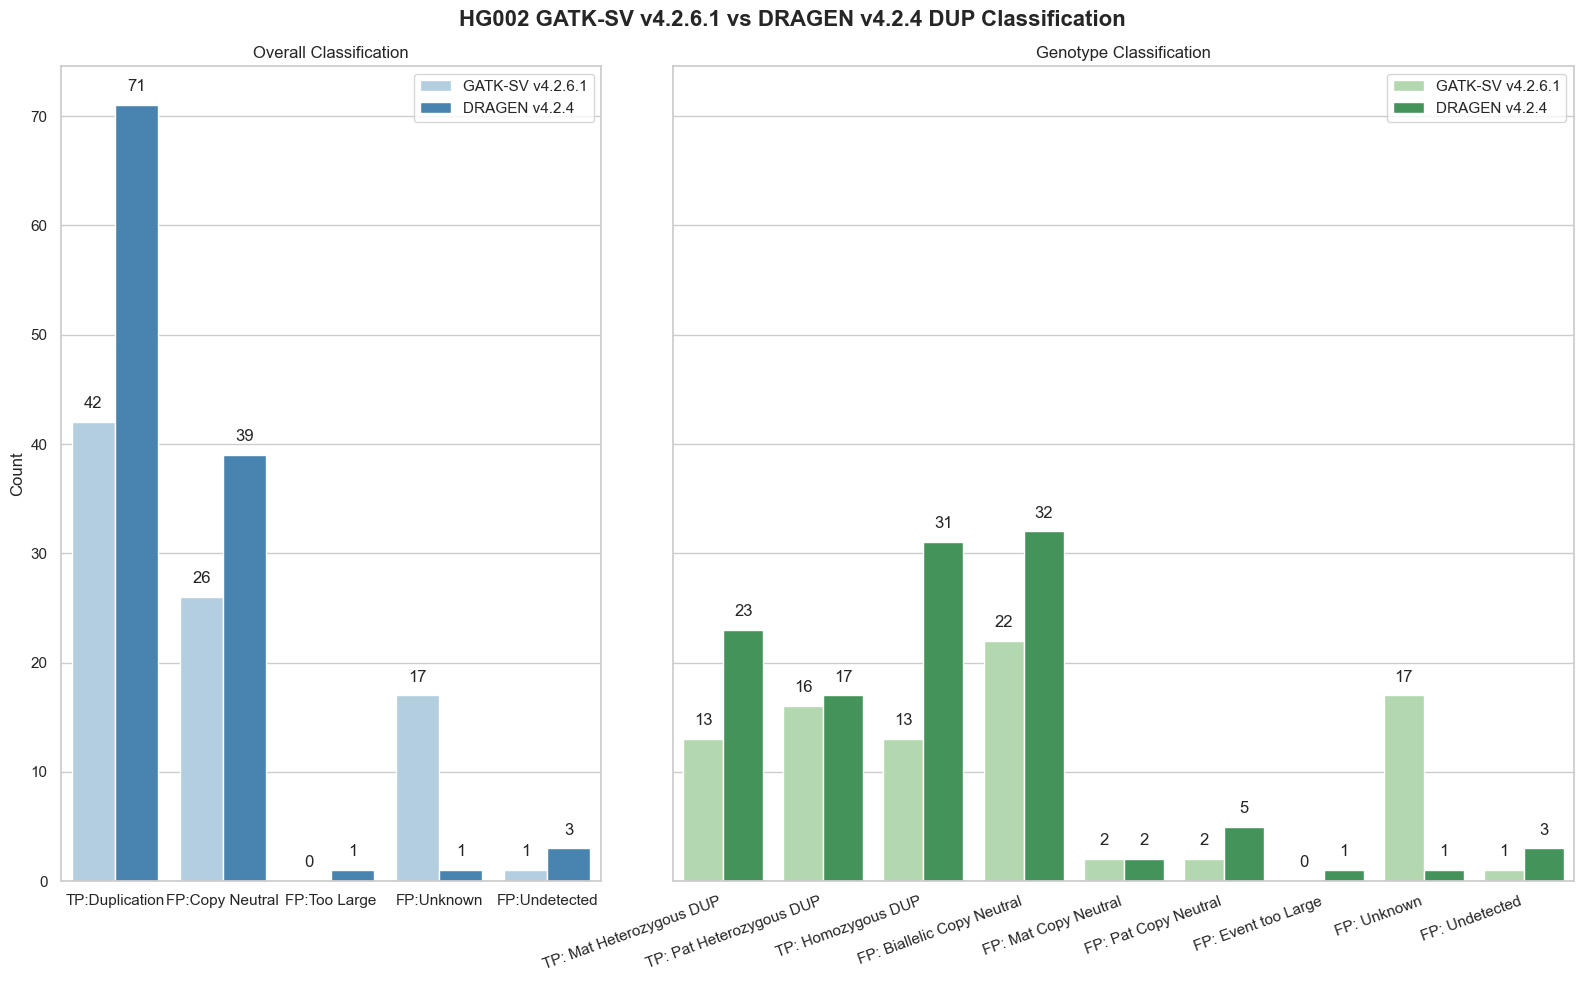

In [98]:
f, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16,10), sharey=True, gridspec_kw={'width_ratios': [1.2, 2]})

maj_bar = sns.barplot(x=maj_count_df.index, y=maj_count_df['Count'], hue=maj_count_df['Caller'], ax=ax0, palette='Blues')
ax0.set_xlabel('')
ax0.set_ylabel('Count')
ax0.set_title('Overall Classification', fontsize=12)
ax0.legend(loc='upper right')

sub_bar = sns.barplot(x=sub_count_df.index, y=sub_count_df['Count'], hue=sub_count_df['Caller'], ax=ax1, palette='Greens')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Genotype Classification', fontsize=12)
ax1.legend(loc='upper right')

plt.xticks(rotation=20, ha='right')

# Annotations for major classifications
for i, rect in enumerate(maj_bar.patches):
    height = rect.get_height()
    ax0.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

# Annotations for sub classifications
for i, rect in enumerate(sub_bar.patches):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 1, 
             f'{int(height)}', ha='center', va='bottom')

plt.suptitle('HG002 GATK-SV v4.2.6.1 vs DRAGEN v4.2.4 DUP Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.savefig('HG002_GATKSV_DRAGEN_DUP_Classification.png', dpi=300)

## Understand the Unknown DUP events

In [92]:
gatksv_hg2_dup_sum_df[gatksv_hg2_dup_sum_df['original_dup_interval_sub_classification']=='Unknown']

,interval,dup_interval_size,original_hg38_hit_count,original_hg2_hit_count,original_hg2_mat_hit_count,original_hg2_pat_hit_count,original_dup_interval_major_classification,original_dup_interval_sub_classification,original_dup_interval_contain_big_gap,corrected_interval,corrected_interval_size,expanded_length,corrected_hg38_hit_count,corrected_hg2_hit_count,corrected_hg2_mat_hit_count,corrected_hg2_pat_hit_count,corrected_dup_interval_major_classification,corrected_dup_interval_sub_classification,corrected_pos_accuracy,corrected_end_accuracy
2,chr1:120807836-120813836,6001,5,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,chr5:70691501-70697808,6308,6,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,chr7:77020001-77034780,14780,6,6,2,4,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,chr8:7712701-7721101,8401,6,6,5,1,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,chr8:8013001-8070001,57001,4,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,chr9:39772901-39789001,16101,4,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,chr9:65251001-65261001,10001,6,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,chr9:65657192-65715192,58001,5,6,4,2,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,chr14:105235638-105240838,5201,6,6,5,1,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,chr15:32388001-32393601,5601,6,6,3,3,Unknown,Unknown,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
dragen_hg2_dup_sum_df[dragen_hg2_dup_sum_df['original_dup_interval_sub_classification']=='Unknown']

,interval,dup_interval_size,original_hg38_hit_count,original_hg2_hit_count,original_hg2_mat_hit_count,original_hg2_pat_hit_count,original_dup_interval_major_classification,original_dup_interval_sub_classification,original_dup_interval_contain_big_gap,corrected_interval,corrected_interval_size,expanded_length,corrected_hg38_hit_count,corrected_hg2_hit_count,corrected_hg2_mat_hit_count,corrected_hg2_pat_hit_count,corrected_dup_interval_major_classification,corrected_dup_interval_sub_classification,corrected_pos_accuracy,corrected_end_accuracy
89,chr20:28861495-28897224,35730,3,5,3,2,Unknown,Unknown,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize the alignment of different DEL events

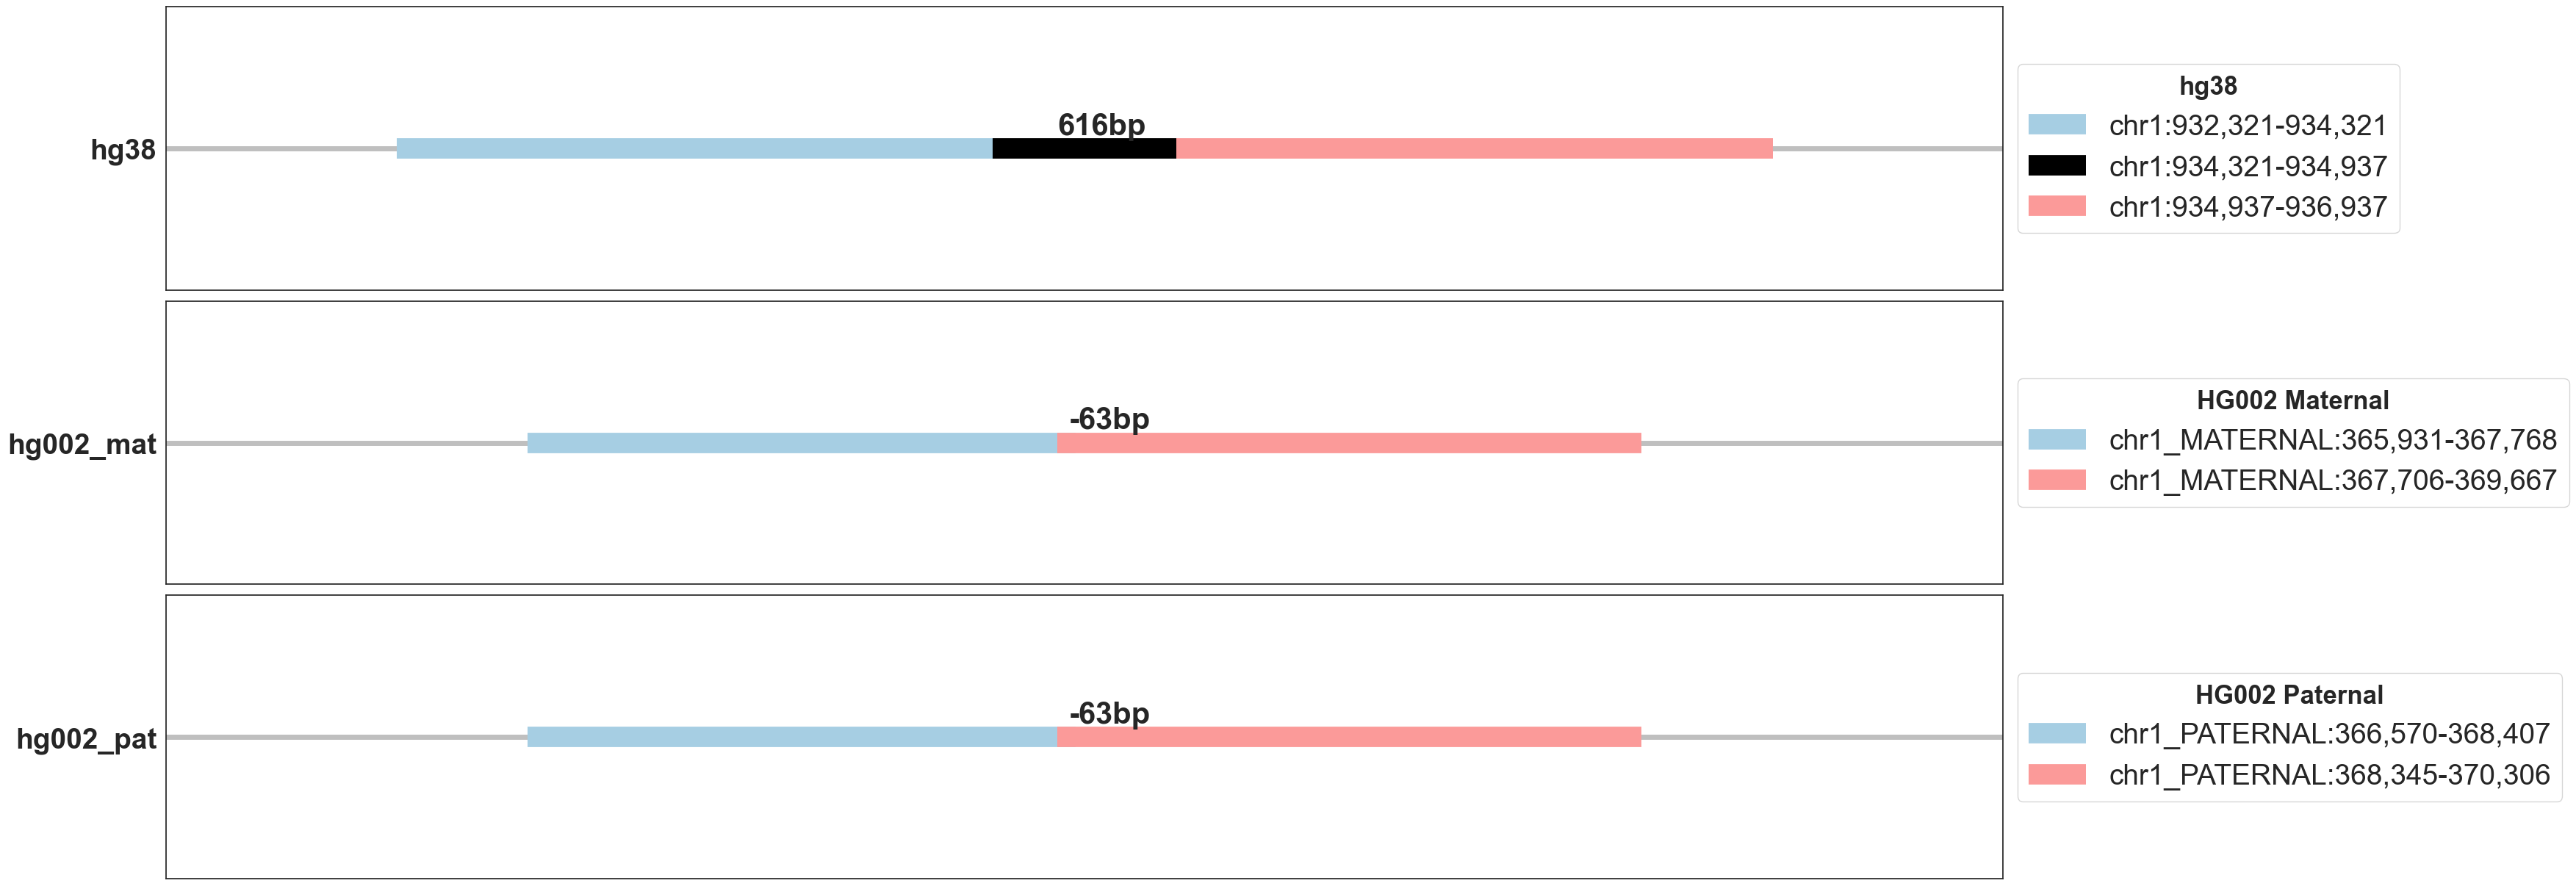

In [107]:
importlib.reload(avu)
avu.PlotIntervals(['chr1:934321-934937', 'chr1:932321-934321', 'chr1:934937-936937'], ['chr1_MATERNAL:365931-367768',
 'chr1_PATERNAL:366570-368407',
 'chr1_MATERNAL:367706-369667',
 'chr1_PATERNAL:368345-370306']).plot_intervals_comparison(flanking=True, save=False,ratio=10)

flanking_size: 2000, copy_threshold: 2
left flanking interval: chr1:58276237-58278237, 2001, 1, 2
right flanking interval: chr1:58279150-58281150, 2001, 1, 2
********** Potential DEL **********
chr1_MATERNAL:58477408-58479408 (2001bp), chr1_MATERNAL:58479408-58481408 (2001bp), -1
********** Potential DEL **********
chr1_PATERNAL:58509469-58511469 (2001bp), chr1_PATERNAL:58511469-58513469 (2001bp), -1


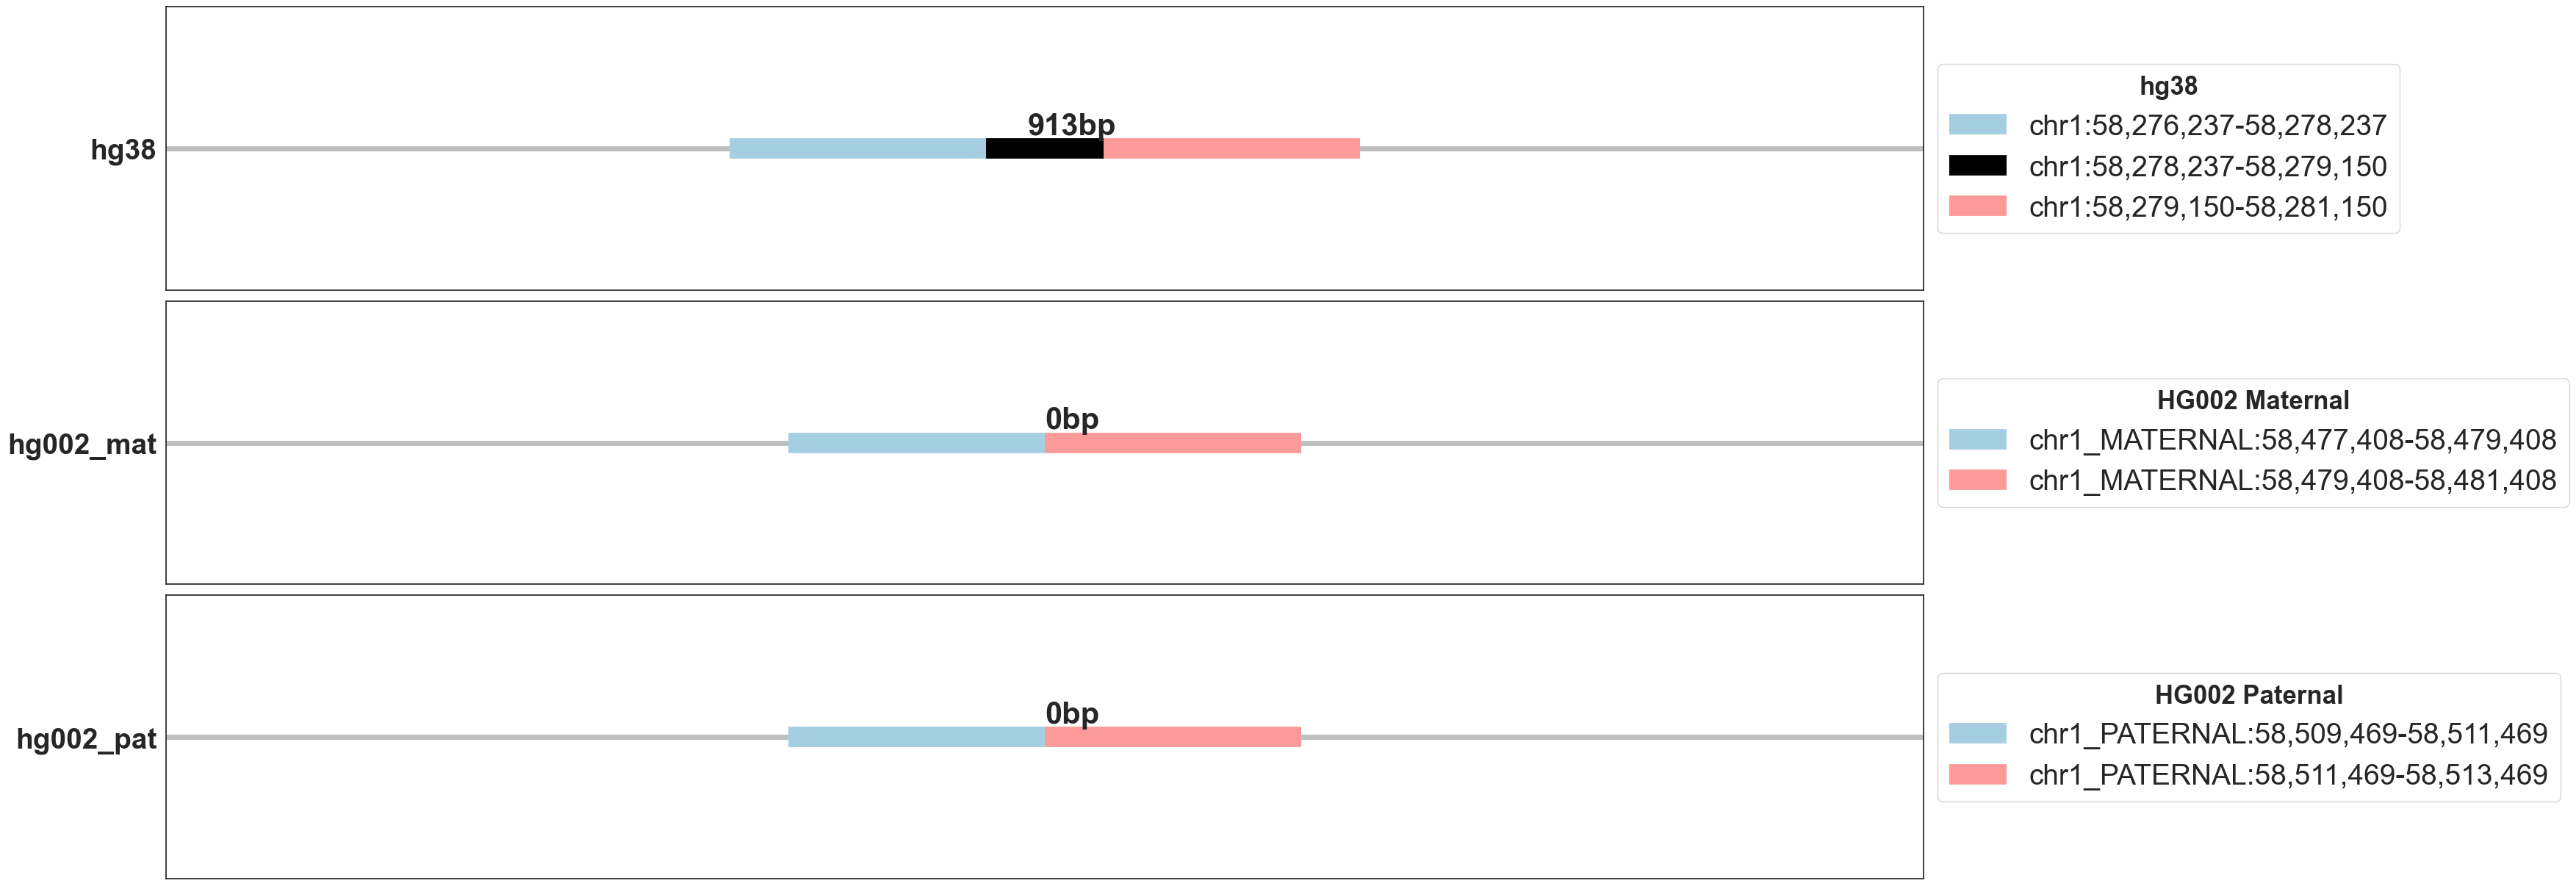

In [114]:
# Example of a Homo DEL
importlib.reload(v)
v.plot_del_flankings("chr1:58278237-58279150", ReferenceLocations.hg38, hg38, hg002t2t, save_plot=True,plot_ratio = 15, save_plot_path="../docs/")

flanking_size: 3854, copy_threshold: 2
left flanking interval: chr4:107138186-107142040, 3855, 1, 2
right flanking interval: chr4:107154888-107158742, 3855, 1, 2
********** Potential DEL **********
chr4_MATERNAL:108520260-108524109 (3850bp), chr4_MATERNAL:108524107-108527961 (3855bp), -3
----------- No DEL Evidence -----------
chr4_PATERNAL:109324423-109328282 (3860bp), chr4_PATERNAL:109341122-109344977 (3856bp), 12839


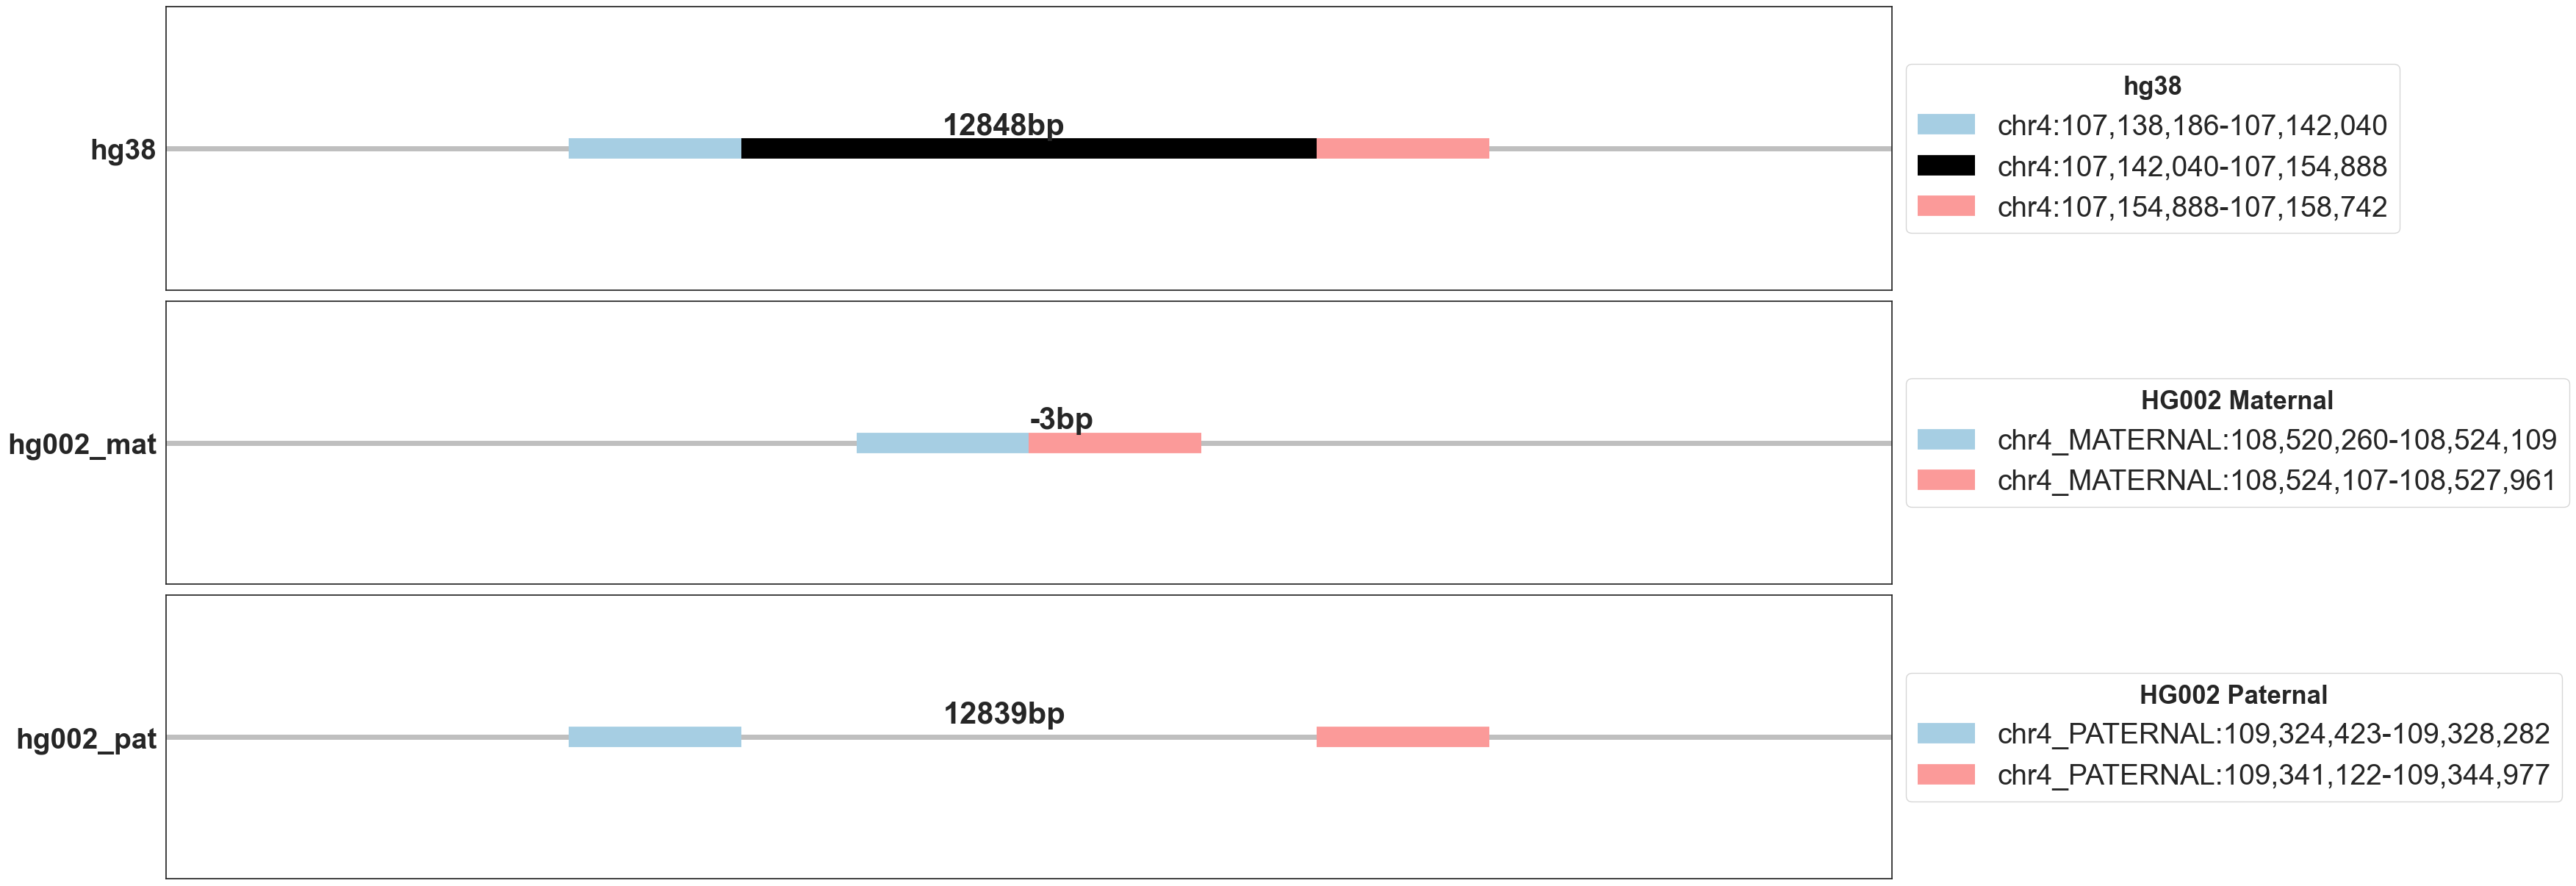

In [120]:
# Plot an example of TP Het event
importlib.reload(v)
v.plot_del_flankings("chr4:107142040-107154888", ReferenceLocations.hg38, hg38, hg002t2t, save_plot=True,plot_ratio = 3, save_plot_path="../docs/")

flanking_size: 2000, copy_threshold: 2
left flanking interval: chr8:77537824-77539824, 2001, 1, 2
right flanking interval: chr8:77540378-77542378, 2001, 1, 2
----------- No DEL Evidence -----------
chr8_PATERNAL:78489402-78491403 (2002bp), chr8_PATERNAL:78491956-78493957 (2002bp), 552
----------- No DEL Evidence -----------
chr8_MATERNAL:78367682-78369683 (2002bp), chr8_MATERNAL:78370236-78372237 (2002bp), 552


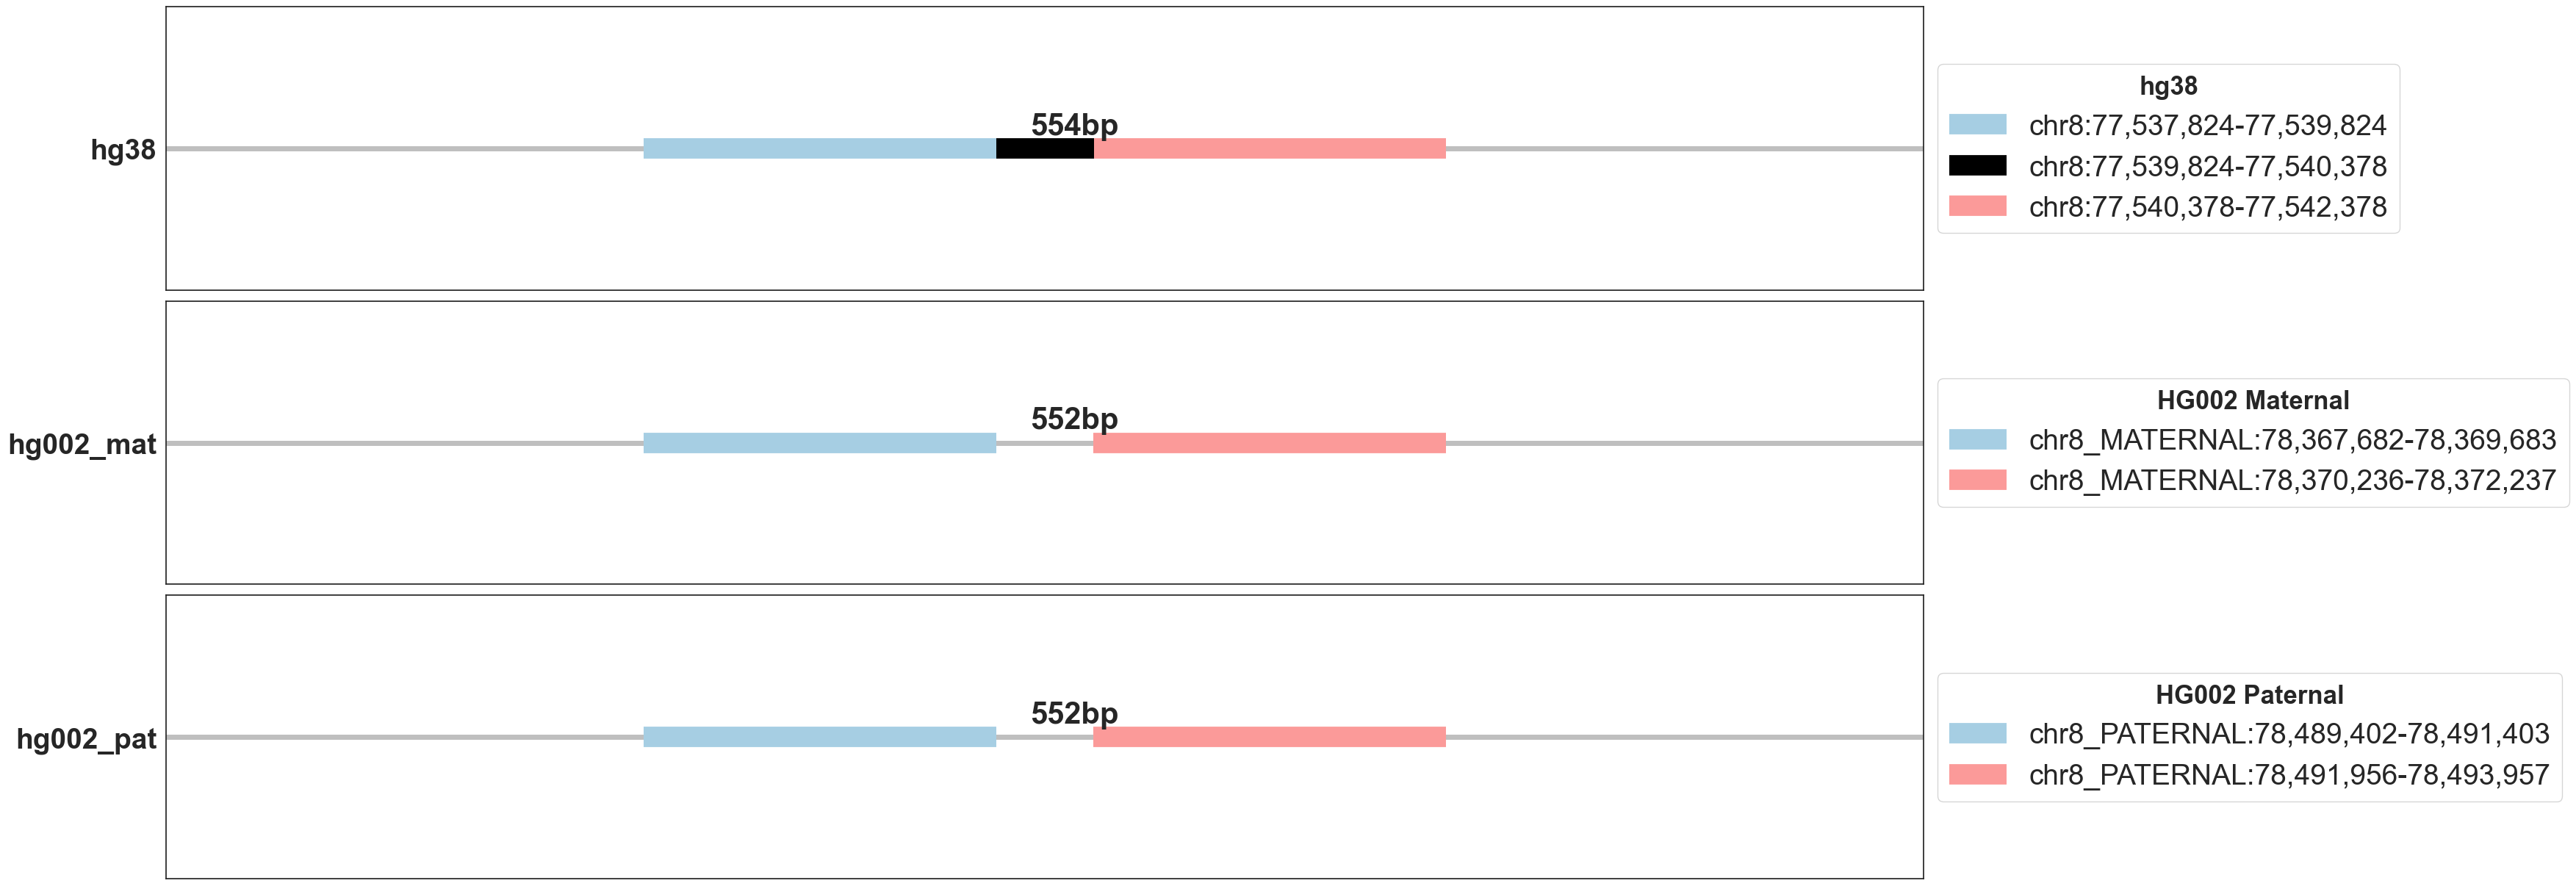

In [123]:
# Example of a FP DEL
v.plot_del_flankings("chr8:77539824-77540378", ReferenceLocations.hg38, hg38, hg002t2t, save_plot=True,plot_ratio = 18, save_plot_path="../docs/")

flanking_size: 2000, copy_threshold: 2
left flanking interval: chr22:11805708-11807708, 2001, 2, 2
right flanking interval: chr22:11809890-11811890, 2001, 2, 2
----------- No DEL Evidence -----------
chr22_PATERNAL:8105319-8107318 (2000bp), chr22_PATERNAL:8109501-8111506 (2006bp), 2182
----------- No DEL Evidence -----------
chr22_MATERNAL:12258241-12260240 (2000bp), chr22_MATERNAL:12262423-12264428 (2006bp), 2182


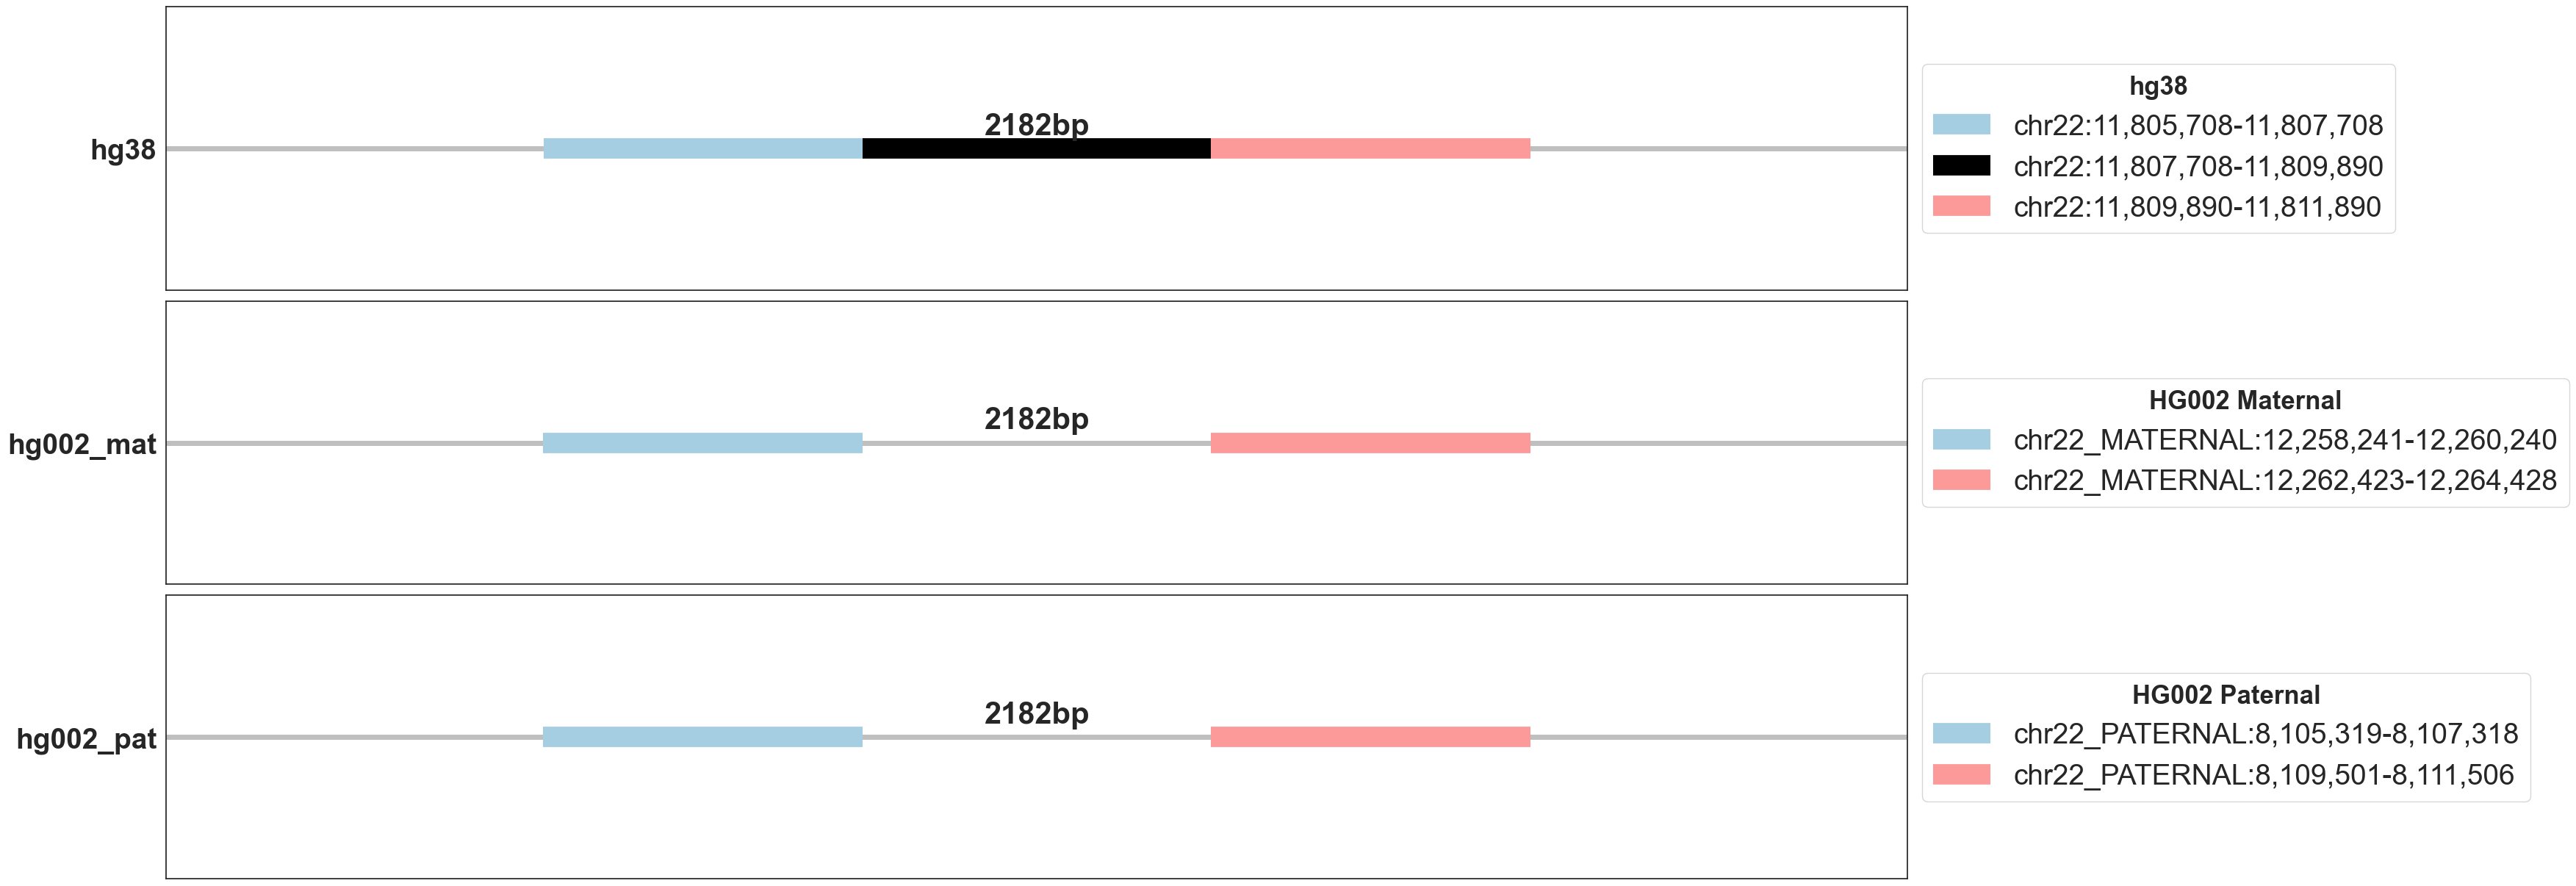

In [130]:
v.plot_del_flankings("chr22:11807708-11809890", ReferenceLocations.hg38, hg38, hg002t2t, save_plot=True,plot_ratio = 5, save_plot_path="../docs/")

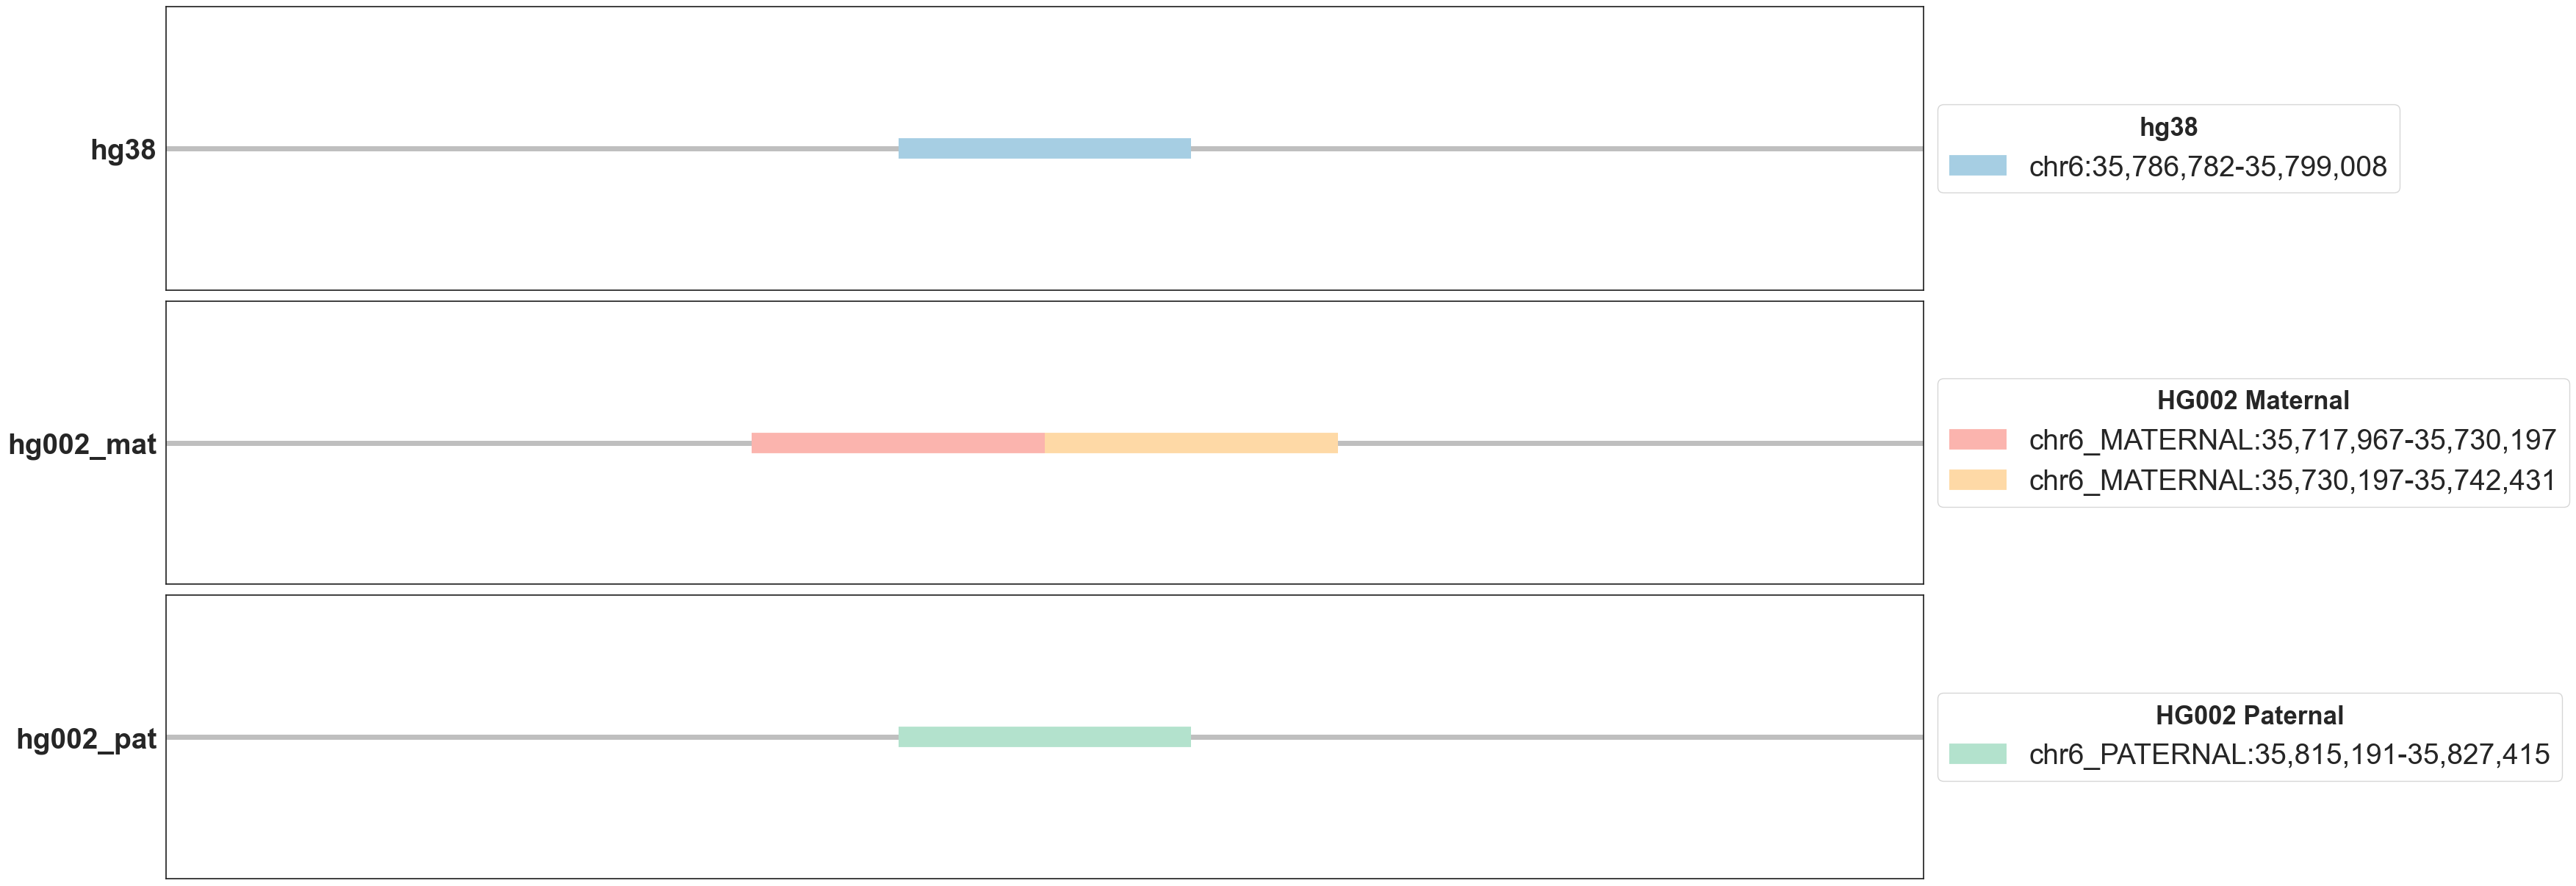

In [136]:
importlib.reload(DuplicationEvaluation)
DuplicationEvaluation.eval_dup_interval("chr6:35786783-35799008", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).plot_alignment(ratio=6, save=True, save_path="../docs/")

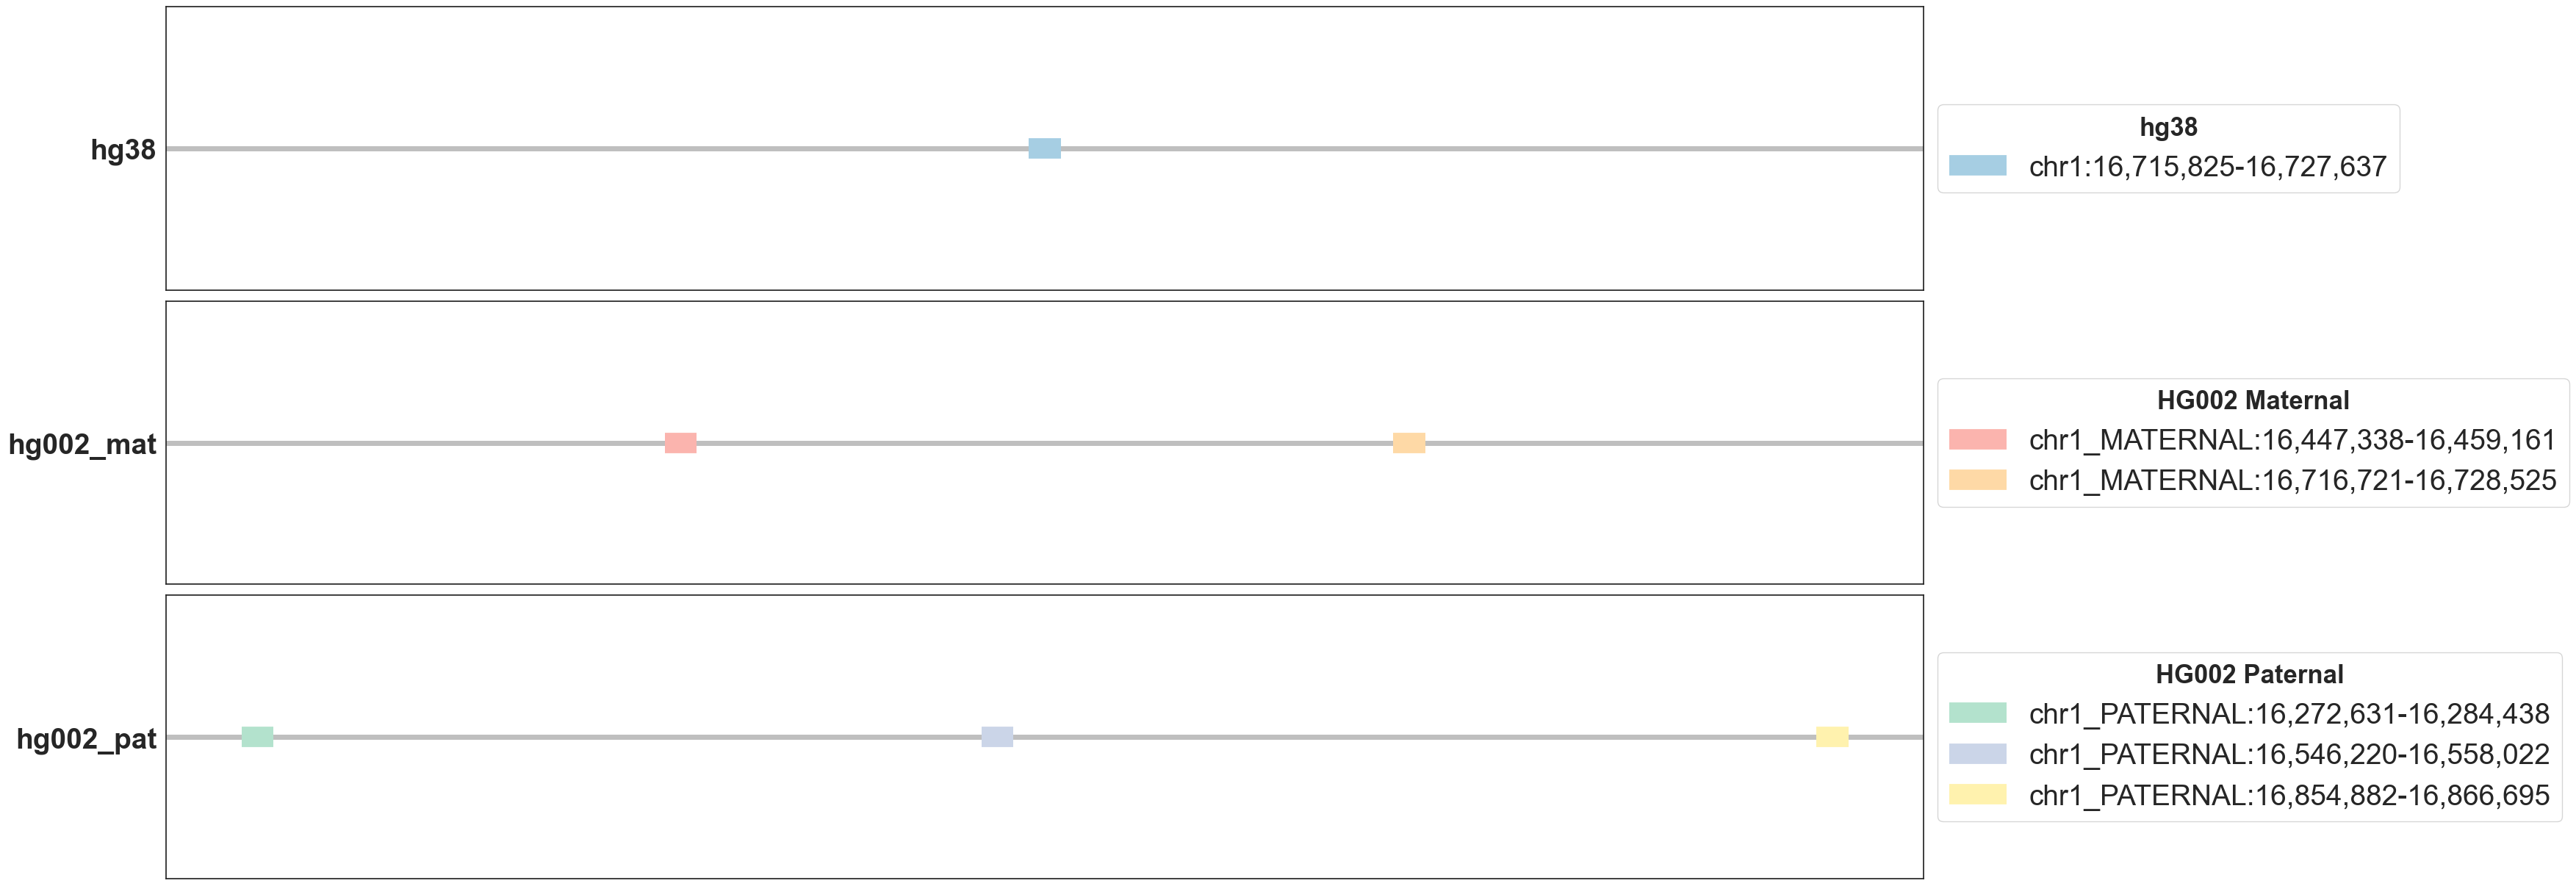

In [149]:
DuplicationEvaluation.eval_dup_interval("chr1:16715826-16727637", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).plot_alignment(ratio=55, save=True, save_path="../docs/")

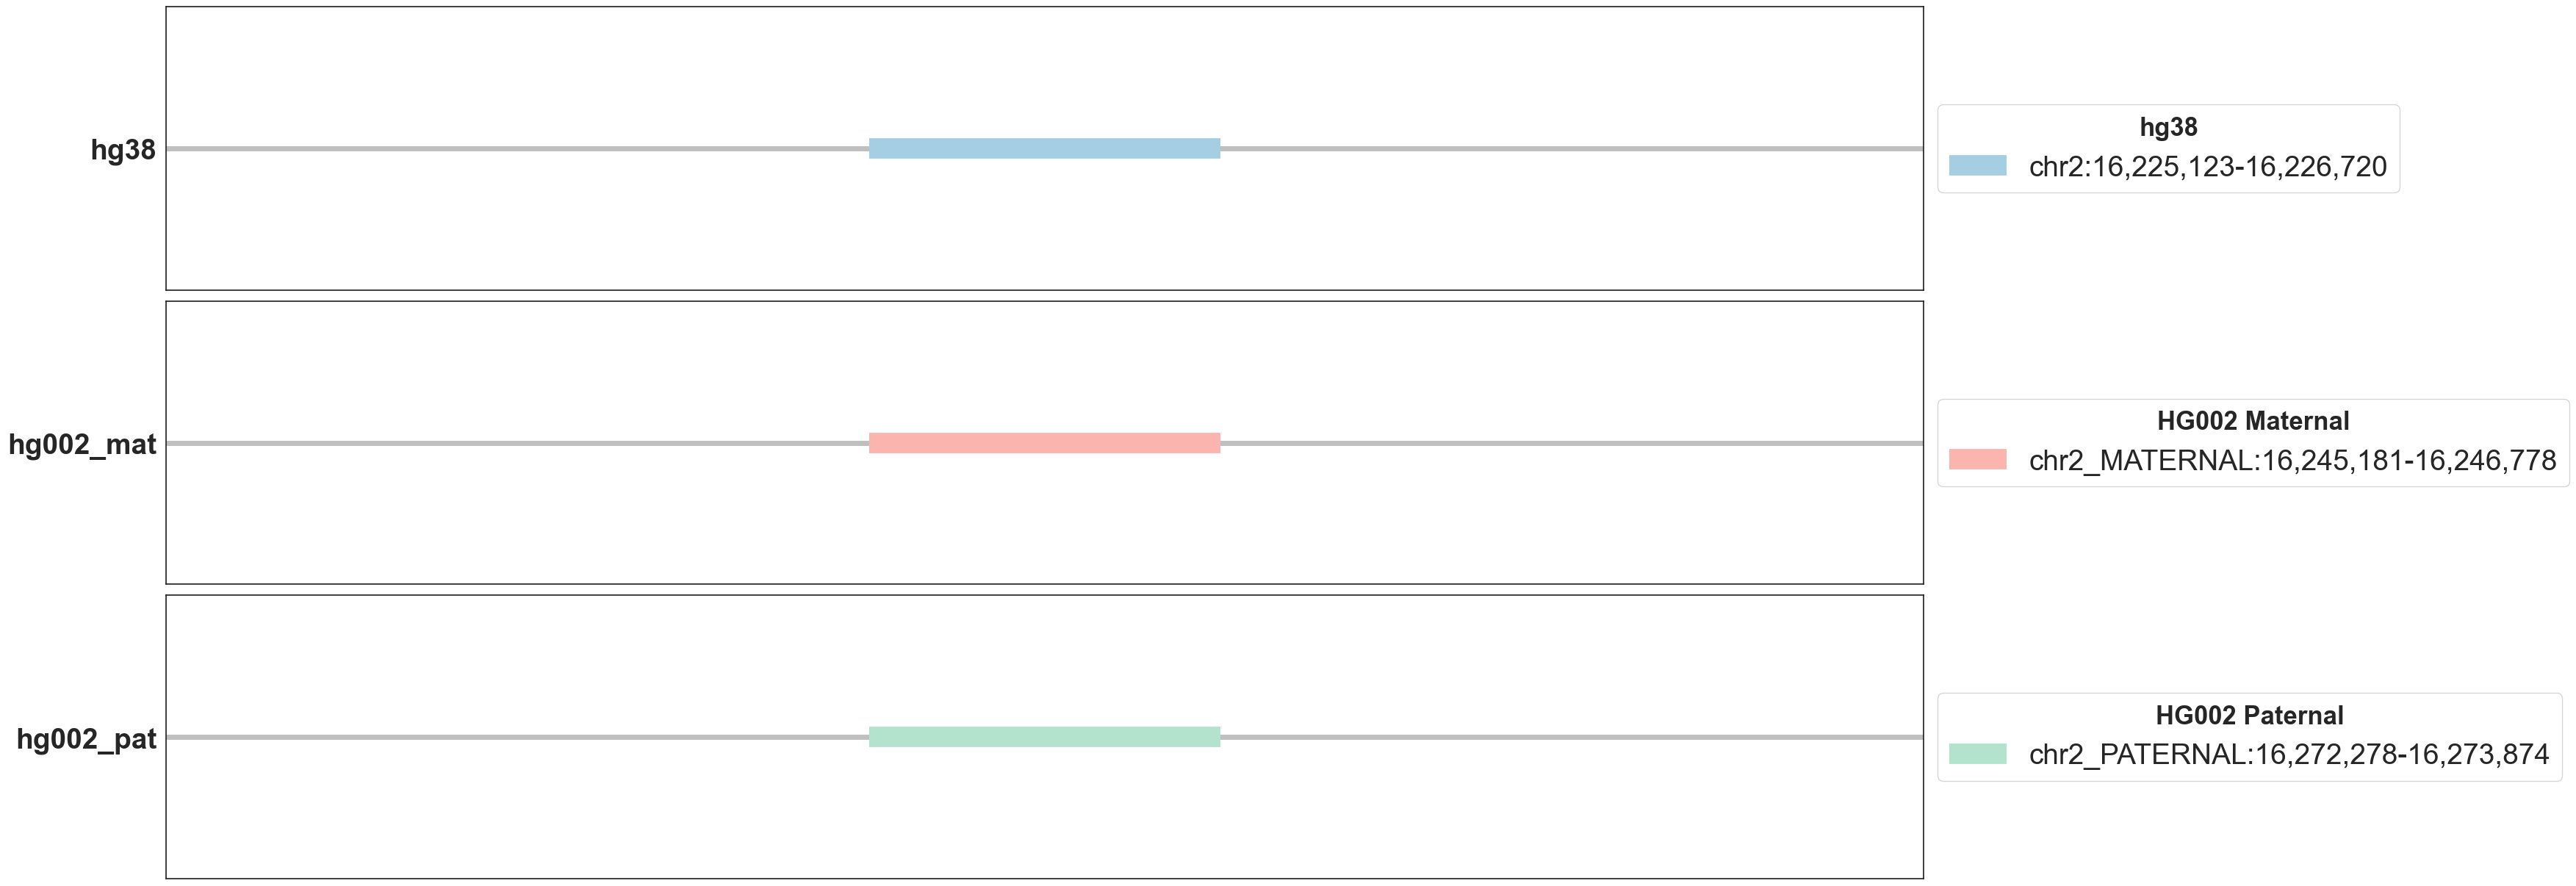

In [152]:
DuplicationEvaluation.eval_dup_interval("chr2:16225124-16226720", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).plot_alignment(ratio=5, save=True, save_path="../docs/")

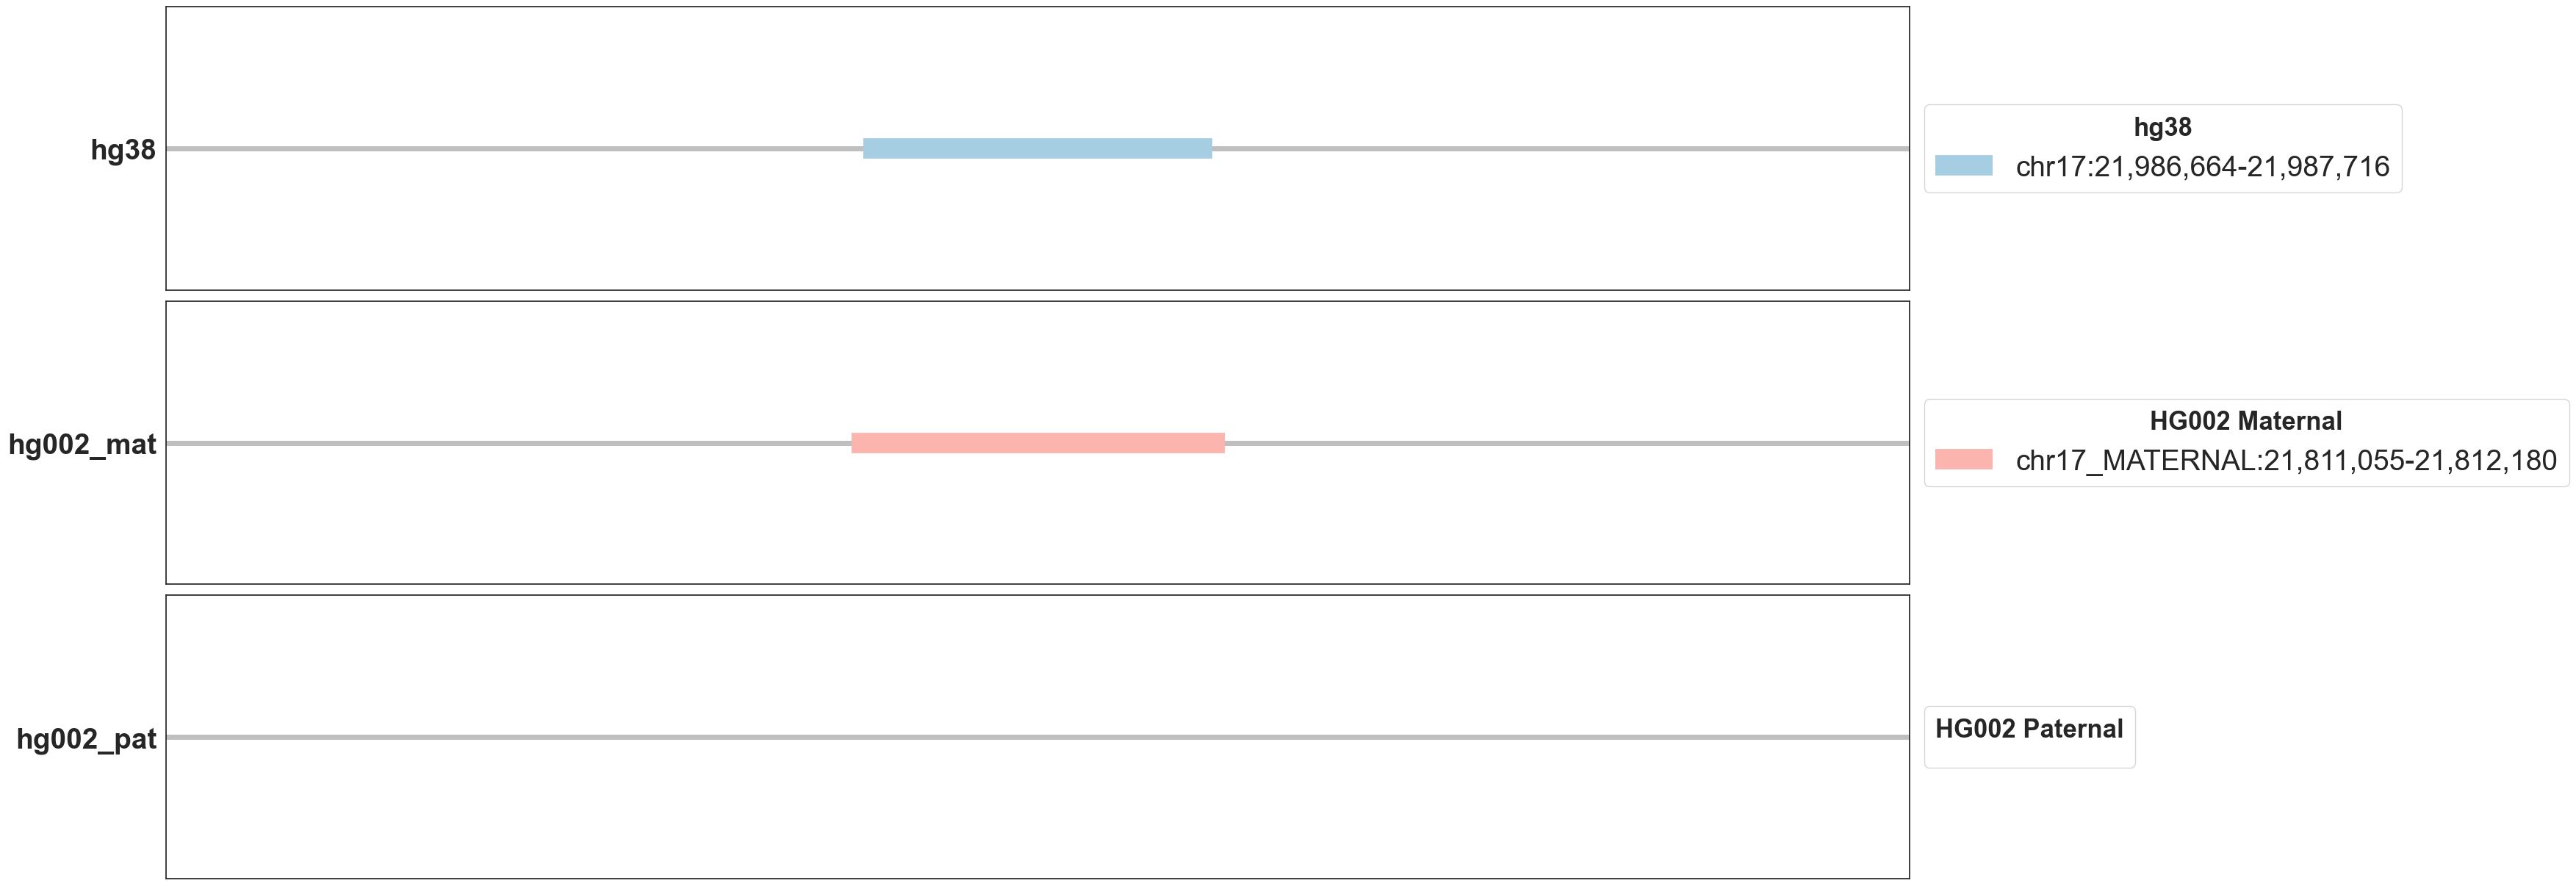

In [158]:
DuplicationEvaluation.eval_dup_interval("chr17:21986665-21987716", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).plot_alignment(ratio=5, save=True, save_path="../docs/")

## Check algorithm that identified FP CNVs in DRAGEN

In [8]:
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
svclaim_dict = {}
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    svclaim = row['INFO'].split('SVCLAIM=')[1].split(';')[0]
    svclaim_dict[interval] = svclaim

#dragen_hg2_dup_sum_df['svclaim'] = dragen_hg2_dup_sum_df['interval'].map(svclaim_dict)

In [9]:
dragen_hg2_dup_sum_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/notebooks/HG002_DRAGEN_DUP_Summary.csv")
dragen_hg2_del_sum_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/notebooks/HG2_DRAGEN_DEL_sum_df.csv")

dragen_hg2_dup_sum_df['svclaim'] = dragen_hg2_dup_sum_df['interval'].map(svclaim_dict)
dragen_hg2_del_sum_df['svclaim'] = dragen_hg2_del_sum_df['del_interval'].map(svclaim_dict)


In [11]:
dragen_hg2_dup_sum_df.to_csv('HG2_DRAGEN_DUP_Summary.csv', index=False)
dragen_hg2_del_sum_df.to_csv('HG2_DRAGEN_DEL_Summary.csv', index=False)

In [14]:
dragen_hg2_dup_sum_df[(dragen_hg2_dup_sum_df['original_dup_interval_major_classification']=='Unknown')|(dragen_hg2_dup_sum_df['original_dup_interval_major_classification']=='Copy Neutral')].to_csv('HG2_DRAGEN_DUP_FP_Summary.csv', index=False)

In [15]:
dragen_hg2_del_sum_df[dragen_hg2_del_sum_df['major_classification']=='False DEL'].to_csv('HG2_DRAGEN_DEL_FP_Summary.csv', index=False)

In [170]:
dragen_hg2_dup_sum_df[dragen_hg2_dup_sum_df['original_dup_interval_major_classification']=='Copy Neutral']['svclaim'].value_counts()

svclaim
D     24
J     13
DJ     2
Name: count, dtype: int64

In [194]:
dragen_hg2_dup_sum_df[(dragen_hg2_dup_sum_df['original_dup_interval_major_classification']=='Copy Neutral')&(dragen_hg2_dup_sum_df['svclaim']=='D')]

,interval,dup_interval_size,original_hg38_hit_count,original_hg2_hit_count,original_hg2_mat_hit_count,original_hg2_pat_hit_count,original_dup_interval_major_classification,original_dup_interval_sub_classification,original_dup_interval_contain_big_gap,corrected_interval,...,expanded_length,corrected_hg38_hit_count,corrected_hg2_hit_count,corrected_hg2_mat_hit_count,corrected_hg2_pat_hit_count,corrected_dup_interval_major_classification,corrected_dup_interval_sub_classification,corrected_pos_accuracy,corrected_end_accuracy,svclaim
11,chr2:91408761-91423450,14690,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
13,chr3:75683120-75707351,24232,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
14,chr3:90558126-90571944,13819,2,2,0,2,Copy Neutral,Paternal Copy Neutral,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
24,chr7:61046337-61058297,11961,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
25,chr7:62297272-62310556,13285,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
26,chr7:62335995-62348128,12134,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
30,chr7:100956437-100972041,15605,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
31,chr7:142341670-142353249,11580,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
37,chr10:38952112-38966576,14465,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
40,chr10:41842555-41856175,13621,1,2,1,1,Copy Neutral,Biallelic Copy Neutral,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D


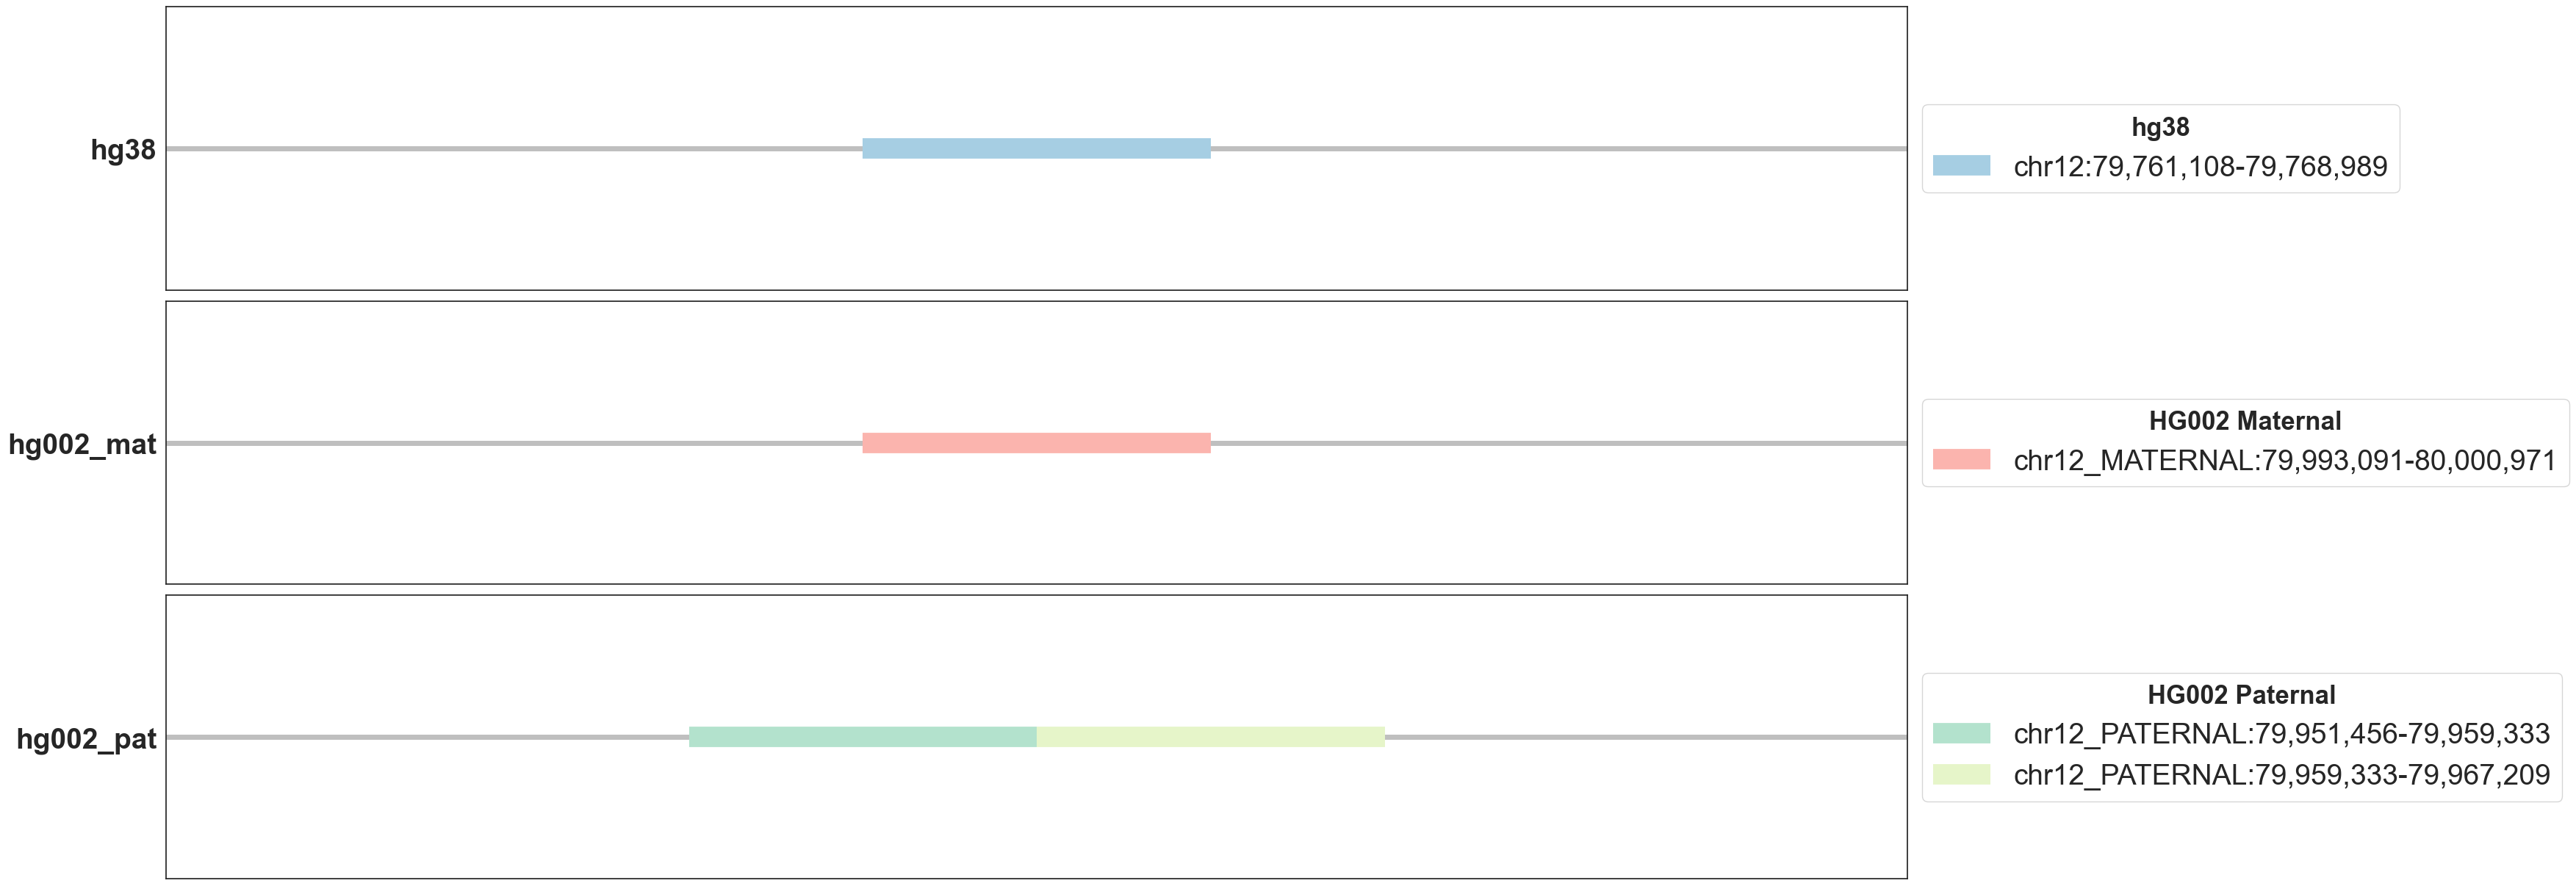

In [182]:
DuplicationEvaluation.eval_dup_interval("chr2:16225124-16226720", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).plot_alignment(ratio=5, save=True, save_path="../docs/")

In [177]:
dragen_hg2_del_sum_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/notebooks/HG2_DRAGEN_DEL_sum_df.csv")
dragen_hg2_del_sum_df['svclaim'] = dragen_hg2_del_sum_df['del_interval'].map(svclaim_dict)
dragen_hg2_del_sum_df[dragen_hg2_del_sum_df['major_classification']=='False DEL']['svclaim'].value_counts()

svclaim
J     31
D     25
DJ     4
Name: count, dtype: int64

## Check algorithm that identified FP CNVs in GATK-SV

In [6]:
HG2_GATK_SV_pass_df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
29,chr1,1565630,NA24385.chr1.final_cleanup_DUP_chr1_20,G,<DUP>,999,PASS,ALGORITHMS=wham;BOTHSIDES_SUPPORT;CHR2=chr1;EN...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:79:3:2:0:99:1:79:RD,SR"
30,chr1,1667010,NA24385.chr1.final_cleanup_DEL_chr1_14,C,<DEL>,999,PASS,ALGORITHMS=manta;BOTHSIDES_SUPPORT;CHR2=chr1;E...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:2:1:9:0:99:1:2:RD,SR"
33,chr1,1948936,NA24385.chr1.final_cleanup_INS_chr1_2,C,<INS>,359,PASS,ALGORITHMS=manta;CHR2=chr1;END=1948984;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:63:.:.:0:99:1:63:SR
36,chr1,2121513,NA24385.chr1.final_cleanup_DEL_chr1_16,T,<DEL>,884,PASS,ALGORITHMS=manta;CHR2=chr1;END=2121638;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:43:4:3:0:99:1:43:SR
38,chr1,2211684,NA24385.chr1.final_cleanup_DUP_chr1_25,T,<DUP>,802,PASS,ALGORITHMS=manta;CHR2=chr1;END=2212195;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,"0/1:0:3:12:1:0:0:0:RD,PE"
...,...,...,...,...,...,...,...,...,...,...
8929,chrY,13114124,NA24385.chrY.final_cleanup_DEL_chrY_12,T,<DEL>,999,PASS,ALGORITHMS=depth;CHR2=chrY;END=13120389;EVIDEN...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:13:0:13:.:.:.:.:RD
8940,chrY,26663817,NA24385.chrY.final_cleanup_DEL_chrY_16,G,<DEL>,653,PASS,ALGORITHMS=wham;CHR2=chrY;END=26663902;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,1/1:89:17:2:0:99:3:89:SR
8943,chrY,56679485,NA24385.chrY.final_cleanup_DEL_chrY_17,A,<DEL>,999,PASS,ALGORITHMS=wham;CHR2=chrY;END=56679574;EVIDENC...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,1/1:94:339:10:0:99:2:94:SR
8949,chrY,56827969,NA24385.chrY.final_cleanup_DEL_chrY_21,C,<DEL>,640,PASS,ALGORITHMS=manta;CHR2=chrY;END=56828131;EVIDEN...,GT:GQ:RD_CN:RD_GQ:PE_GT:PE_GQ:SR_GT:SR_GQ:EV,0/1:0:4:0:0:99:1:0:SR


In [10]:
algorithm_dict = {}
for index, row in HG2_GATK_SV_pass_df.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    algorithm = row['INFO'].split('ALGORITHMS=')[1].split(';')[0]
    algorithm_dict[interval] = algorithm
print(set(algorithm_dict.values()))

{'depth,wham', 'depth,manta', 'wham', 'depth', 'manta', 'manta,wham', 'depth,manta,wham', 'manta,rescan'}


In [11]:
len(algorithm_dict.keys())

5373

In [12]:
gatksv_hg2_dup_sum_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/notebooks/HG002_GATKSV_DUP_Summary.csv")
gatksv_hg2_del_sum_df = pd.read_csv("/Users/gaoyueya/Documents/GitHub/T2T-ACE/notebooks/HG2_GATKSV_DEL_sum_df.csv")

gatksv_hg2_dup_sum_df['algorithm'] = gatksv_hg2_dup_sum_df['interval'].map(algorithm_dict)
gatksv_hg2_del_sum_df['algorithm'] = gatksv_hg2_del_sum_df['del_interval'].map(algorithm_dict)

In [32]:
gatksv_hg2_dup_sum_df[gatksv_hg2_dup_sum_df['original_dup_interval_major_classification']=='Copy Neutral']['algorithm'].value_counts()

algorithm
depth          24
depth,manta     2
Name: count, dtype: int64

In [33]:
gatksv_hg2_dup_sum_df[gatksv_hg2_dup_sum_df['original_dup_interval_major_classification']=='Unknown']['algorithm'].value_counts()

algorithm
depth    17
Name: count, dtype: int64

In [30]:
gatksv_hg2_del_sum_df['major_classification'].value_counts()

major_classification
DEL          640
False DEL     75
Unknown        6
Name: count, dtype: int64

In [31]:
gatksv_hg2_del_sum_df[gatksv_hg2_del_sum_df['major_classification']=="False DEL"]['algorithm'].value_counts()

algorithm
depth         50
wham          12
manta         12
manta,wham     1
Name: count, dtype: int64

In [13]:
gatksv_hg2_dup_sum_df[(gatksv_hg2_dup_sum_df['original_dup_interval_major_classification']=="Unknown")|(gatksv_hg2_dup_sum_df['original_dup_interval_major_classification']=="Copy Neutral")].to_csv("HG2_GATKSV_DUP_FPs.csv", index=False)

In [44]:
gatksv_hg2_del_sum_df[gatksv_hg2_del_sum_df['major_classification']=="False DEL"].to_csv("HG2_GATKSV_DEL_FPs.csv", index=False)

## Check Performance of Individual CNV Performance

In [39]:
HG2_GATK_SV_pass_df[(HG2_GATK_SV_pass_df['CHROM']=='chr1')&(HG2_GATK_SV_pass_df['POS']==25259164)]['INFO'].item()

'ALGORITHMS=depth;CHR2=chr1;END=25265164;EVIDENCE=RD;PREDICTED_INTERGENIC;PREDICTED_NEAREST_TSS=RHD;PREDICTED_NONCODING_BREAKPOINT=Tommerup_TADanno;PREDICTED_NONCODING_SPAN=DNase;SVLEN=6000;SVTYPE=DEL;AN=2;AC=1;AF=0.003185;N_BI_GENOS=157;N_HOMREF=156;N_HET=1;N_HOMALT=0;FREQ_HOMREF=0.993631;FREQ_HET=0.00636943;FREQ_HOMALT=0;gnomad_v2.1_sv_SVID=gnomAD-SV_v2.1_DEL_1_1936;gnomad_v2.1_sv_AF=0.000214;gnomad_v2.1_sv_AFR_AF=0.000252;gnomad_v2.1_sv_AMR_AF=0.000564;gnomad_v2.1_sv_EAS_AF=0;gnomad_v2.1_sv_EUR_AF=0'

In [42]:
HG2_GATK_SV_pass_df[(HG2_GATK_SV_pass_df['CHROM']=='chr1')&(HG2_GATK_SV_pass_df['POS']==25259164)]['SAMPLE'].item()

'0/1:9:1:9:.:.:.:.:RD'

In [46]:
import T2T_ACE.validator as v
importlib.reload(v)
v.collect_del_flankings("chr1:109677059-109697824", ReferenceLocations.hg38, hg38, hg002t2t)

DEL interval: chr1:109677059-109697824 20766
DEL interval Alignments in hg38: 1
DEL interval Alignments in HG2: 1
flanking_size: 6229, copy_threshold: 2
left flanking interval: chr1:109670830-109677059, 6230, 1, 2
right flanking interval: chr1:109697824-109704053, 6230, 1, 3
********** Potential DEL **********
chr1_PATERNAL:109924049-109930279 (6231bp), chr1_PATERNAL:109932598-109938411 (5814bp), 2318
********** Potential DEL **********
chr1_MATERNAL:109841112-109847340 (6229bp), chr1_MATERNAL:109849657-109855886 (6230bp), 2316


{'del_interval': 'chr1:109677059-109697824',
 'del_interval_size': 20766,
 'flanking_size': 6229,
 'left_flanking_interval': 'chr1:109670830-109677059',
 'right_flanking_interval': 'chr1:109697824-109704053',
 'left_flanking_hg38_hits': 1,
 'right_flanking_hg38_hits': 1,
 'left_flanking_hg2_hits': 2,
 'right_flanking_hg2_hits': 3,
 'distance_between_flankings': [2318, 2316],
 'flanking_connection_strand': ['POS', 'POS'],
 'hg38_plotting_flanking_intervals': ['chr1:109677059-109697824',
  'chr1:109670830-109677059',
  'chr1:109697824-109704053'],
 'hg2_plotting_flanking_intervals': ['chr1_PATERNAL:109924049-109930279',
  'chr1_MATERNAL:109841112-109847340',
  'chr1_PATERNAL:109932598-109938411',
  'chr1_MATERNAL:109849657-109855886'],
 'classification': 'DEL',
 'minor_classification': 'Homozygous DEL'}

In [196]:
DuplicationEvaluation.eval_dup_interval("chr3:75683120-75707351", ReferenceLocations.hg38, ReferenceLocations.hg002t2t, hg38, hg002t2t).analyzeDuplicationIntervals()

----------------------------------------------------------------
Alignment Report of Original Interval
----------------------------------------------------------------
input dup interval: chr3:75683120-75707351
hg38 dup count: 1
interval: chr3:75683119-75707351	strand: 1, start: 0, end: 24232
hg2 dup count: 2
interval: chr3_MATERNAL:75657589-75681728	strand: 1, start: 0, end: 24232
interval: chr3_PATERNAL:75739040-75763284	strand: 1, start: 0, end: 24232
The DUP interval's classification is Copy Neutral and it will not be corrected
----------------------------------------------------------------
End of Analysis of DUP interval chr3:75683120-75707351(24232bp)
----------------------------------------------------------------


{'dup_interval': 'chr3:75683120-75707351',
 'dup_interval_size': 24232,
 'original_hg38_hit_count': 1,
 'original_hg2_hit_count': 2,
 'original_hg2_mat_hit_count': 1,
 'original_hg2_pat_hit_count': 1,
 'original_dup_interval_major_classification': 'Copy Neutral',
 'original_dup_interval_sub_classification': 'Biallelic Copy Neutral',
 'original_dup_interval_contain_big_gap': False,
 'corrected_interval': nan,
 'corrected_interval_size': nan,
 'expanded_length': nan,
 'corrected_hg38_hit_count': nan,
 'corrected_hg2_hit_count': nan,
 'corrected_hg2_mat_hit_count': nan,
 'corrected_hg2_pat_hit_count': nan,
 'corrected_dup_interval_major_classification': nan,
 'corrected_dup_interval_sub_classification': nan,
 'corrected_pos_accuracy': nan,
 'corrected_end_accuracy': nan}